# Recommendations with IBM

This Notebook recommendations methodologies on actual data from the IBM Watson Studio platform. The recommendations method can be exploited for similar projects. 


## Table of Contents

* [Exploratory Data Analysis](#Exploratory-Data-Analysis)
* [Rank Based Recommendations](#Rank)
* [User-User Based Collaborative Filtering](#User-User)
* [Content Based Recommendations](#Content-Recs)
* [Matrix Factorization](#Matrix-Fact)
* [Extras & Concluding](#conclusions)

In [2]:
# Importing the required libraries
import numpy as np
import pandas as pd
import project_tests as t
import pickle
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
%matplotlib inline

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('abc')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /Users/NS/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/NS/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package abc to /Users/NS/nltk_data...
[nltk_data]   Package abc is already up-to-date!
[nltk_data] Downloading package punkt to /Users/NS/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Loading user-intraction & article-description data
df = pd.read_csv('Data/user-item-interactions.csv')
df_content = pd.read_csv('Data/articles_community.csv')

In [4]:
# Exploring a glimps of the dataframe 
df.head()

,Unnamed: 0,article_id,title,email
0,0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [5]:
# Exploring a glimps of the dataframe 
df_content.head()

,Unnamed: 0,doc_body,doc_description,doc_full_name,doc_status,article_id
0,3,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,5,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,7,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,8,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,12,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [6]:
# Removing unneccsary columns 
del df['Unnamed: 0']
del df_content['Unnamed: 0']

In [7]:
# Verifing the removals 
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [8]:
# Verifing the removals 
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [9]:
df_number = df.groupby(['email']).size().reset_index(name='article_counts')
df_number = df_number.sort_values(by=['article_counts'], ascending=False)
df_number

,email,article_counts
910,2b6c0f514c2f2b04ad3c4583407dccd0810469ee,364
2426,77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a,363
985,2f5c7feae533ce046f2cb16fb3a29fe00528ed66,170
3312,a37adec71b667b297ed2440a9ff7dad427c7ac85,169
2680,8510a5010a5d4c89f5b07baac6de80cd12cfaf93,160
...,...,...
565,1b520f0f65c0aee52d4235f92fb2de58fa966635,1
2481,7a67e4a2902a20062e1f2a6835b6e099b34b4f6c,1
4003,c4b7e639e91b1d18e5b9c000f0ad3354888fcdde,1
2483,7a7fb282789944665ffc1cddee5ddbdbd7ca9f64,1


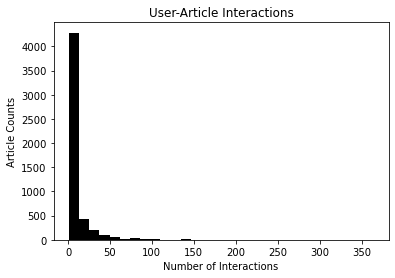

In [10]:
x = df_number['article_counts']
plt.hist(x, bins=30, color='black');
plt.xlabel('Number of Interactions');
plt.ylabel('Article Counts')
plt.title('User-Article Interactions');
plt.show()

In [11]:
# The median and maximum number of user_article interactios (* prints only the values)
median_val = df_number.median()
print("50% of individuals interact with {} number of articles or fewer.".format(*median_val)) 

max_views_by_user = df_number['article_counts'].max()
print("The maximum number of user-article interactions by any 1 user is {}.".format(max_views_by_user))

50% of individuals interact with 3.0 number of articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [12]:
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   doc_body         1042 non-null   object
 1   doc_description  1053 non-null   object
 2   doc_full_name    1056 non-null   object
 3   doc_status       1056 non-null   object
 4   article_id       1056 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 41.4+ KB


In [13]:
# Identifying duplicate articles
df_content.duplicated(['article_id']).sum()

5

In [14]:
df_cont_dup = np.where(df_content.duplicated(['article_id']))
df_cont_dup

(array([365, 692, 761, 970, 971]),)

In [15]:
# Checking if there are any article ids which are duplicates
df_cont_dup = np.where(df_content.duplicated(['article_id']))

# Display the dataframe of duplicated ids
for id in df_cont_dup[0]:
    display(df_content[df_content['article_id'] == id])

,doc_body,doc_description,doc_full_name,doc_status,article_id
366,GO SERVERLESS WITH APEX AND COMPOSE'S MONGODB\...,While AWS's Lambda service treats each functio...,Go Serverless with Apex and Compose's MongoDB,Live,365


,doc_body,doc_description,doc_full_name,doc_status,article_id
694,Skip to content * Unix\r\n * R\r\n\r\n15 PAGE ...,"For Beginners in R, here is a 15 page example ...",15 Page Tutorial for R,Live,692


,doc_body,doc_description,doc_full_name,doc_status,article_id
764,Elvis Dohmatob Home Blog Publications Photos C...,"In this post, I’ll demo variational auto-encod...","Variational auto-encoder for ""Frey faces"" usin...",Live,761


,doc_body,doc_description,doc_full_name,doc_status,article_id
975,Compose The Compose logo Articles Sign in Free...,"In this third article in our the series, we'll...",Launching RESTHeart into Production,Live,970


,doc_body,doc_description,doc_full_name,doc_status,article_id
976,Cloudant allows custom Javascript to be run se...,Cloudant allows custom Javascript to be run se...,Defensive coding in Map/Index functions,Live,971


In [16]:
# Removing duplicates on article ids
df_cont_Dup_drop = df_content.drop_duplicates(subset='article_id', keep='first')
df_cont_Dup_drop.shape

(1051, 5)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [17]:
df.nunique()

article_id     714
title          714
email         5148
dtype: int64

In [18]:
df.groupby(['article_id']).count().sort_values('title', ascending=False).head()

,title,email
article_id,,
1429.0,937,937
1330.0,927,927
1431.0,671,671
1427.0,643,643
1364.0,627,627


In [19]:
df.groupby(['email']).count().head()

,article_id,title
email,,
0000b6387a0366322d7fbfc6434af145adf7fed1,13,13
001055fc0bb67f71e8fa17002342b256a30254cd,4,4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621,3,3
001a852ecbd6cc12ab77a785efa137b2646505fe,6,6
001fc95b90da5c3cb12c501d201a915e4f093290,2,2


In [20]:
print(df.shape, df_cont_Dup_drop.shape)

(45993, 3) (1051, 5)


In [21]:
unique_articles = df.nunique()
unique_articles

article_id     714
title          714
email         5148
dtype: int64

In [22]:
# The number of unique articles that have at least one interaction
unique_articles = df.nunique()['article_id'] 

# The number of unique articles on the IBM platform
total_articles = df_cont_Dup_drop.shape[0] 

# The number of unique users
unique_users = df.nunique()['email'] 

# The number of user-article interactions
user_article_interactions = df.shape[0] 


print("The number of unique articles that have at least one interaction is {}.".format(unique_articles))
print("The number of unique articles on the IBM platform is {}.".format(total_articles))
print("The number of unique users is {}.".format(unique_users))
print("The number of user-article interactions is {}.".format(user_article_interactions))

The number of unique articles that have at least one interaction is 714.
The number of unique articles on the IBM platform is 1051.
The number of unique users is 5148.
The number of user-article interactions is 45993.


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [30]:
# Checking the most viewed article and its viewing counts
df_view_most = df.groupby(['article_id']).count()
df_view_most['email'].max()
display(df_view_most.loc[df_view_most['email'] == df_view_most['email'].max()])

,title,email
article_id,,
1429.0,937,937


In [ ]:
# The most viewed article in the dataset 
most_viewed_article_id = "1429.0" 

# The most viewed article in the dataset was viewed how many times?
max_views = 937 

In [ ]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

In [ ]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [ ]:
df.head()

In [ ]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = df.groupby(['article_id', 'title']).size()\
                        .reset_index(name='counts').sort_values('counts', ascending=False)[:n].title.tolist()
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = df.groupby("article_id").count()["title"].sort_values(ascending=False).index[:n].astype('str')
    return top_articles # Return the top article ids

In [ ]:
print(get_top_articles(10))
print(get_top_article_ids(10))

In [ ]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

In [ ]:
### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [ ]:
# Create the user-article matrix with 1's and 0's
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    # unstack the user-item interaction dataframe
    user_item = df.drop_duplicates().groupby(['user_id', 'article_id']).size().unstack()
    
    # fill missing values with 0
    user_item = user_item.fillna(0)
    
    # convert int
    user_item = user_item.astype('int')
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [ ]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [ ]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # Compute similarity of each user to the provided user
    user_similr = user_item.loc[user_id,:].dot(user_item.T)

    # Sort by similarity
    user_similr  = user_similr.sort_values(ascending = False)

    # Create list of just the ids
    # Remove the own user's id
    most_similar_users = user_similr.loc[~(user_similr.index ==  user_id)].index.values.tolist()
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [ ]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [ ]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = []
    # Select articles with the same article_id and drop duplicates 
    article_names = df[df['article_id'].isin(article_ids)]['title'].drop_duplicates().values.tolist()

    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    # Get all articles for this user id
    user_idx = user_item.loc[user_id,:]
    # Get articles user interacted with
    article_ids = user_idx[user_idx == 1].index.values.astype('str').tolist()
    # Get article names 
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    # Get most similar users 
    most_similar_users = find_similar_users(user_id)
    # Get article ids 
    user_article_ids = set(get_user_articles(user_id)[0])
    recs = []
    # Create recommendations for this user
    for user_neighb in most_similar_users:
        neighb_article_ids = set(get_user_articles(user_neighb)[0])
        recs += list(set(neighb_article_ids) - set(user_article_ids))
        if len(recs) > m:
            break
    recs = recs[:m]
    
    return recs # return your recommendations for this user_id 

In [ ]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

In [ ]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")